In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from CAMUS import CAMUS_score, CAMUS_prioritize, precluster_scRNA_scST

import warnings
warnings.filterwarnings("ignore")

## 1. We first load the annotated adata (collected from the retina of chick)

In [2]:
adata_raw = sc.read_h5ad('../data/Chick_P10_annotated.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 13819 × 14300
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Cell.type', 'tSNE.1', 'tSNE.2', 'nGene', 'nUMI', 'Percentage.of.mitochondrial.genes', 'Percentage.of.ribosomal.protein.genes', 'cell_type1', 'cell_ontology_class', 'time_treatment', 'time', 'Macosko_CAME', 'Menon_microfluidics_CAME', 'Menon_seqwell_CAME', 'mouse_LD_0hr_CAME', 'mouse_LD_10hr_CAME', 'mouse_LD_24hr_CAME', 'mouse_LD_4hr_CAME', 'mouse_LD_P60_CAME', 'mouse_NMDA_12hr_CAME', 'mouse_NMDA_24hr_CAME', 'mouse_NMDA_36hr_CAME', 'mouse_NMDA_3hr_CAME', 'mouse_NMDA_48hr_CAME', 'mouse_NMDA_6hr_CAME', 'mouse_NMDA_72hr_CAME', 'mouse_NMDA_P60_CAME', 'zebrafish_LD_10hr_CAME', 'zebrafish_LD_20hr_CAME', 'zebrafish_LD_36hr_CAME', 'zebrafish_LD_4hr_CAME', 'zebrafish_LD_Adult_CAME', 'zebrafish_NMDA_10hr_CAME', 'zebrafish_NMDA_20hr_CAME', 'zebrafish_NMDA_36hr_CAME', 'zebrafish_NMDA_4hr_CAME', 'zebrafish_NMDA_Adult_CAME', 'zebrafish_TNFa_10hr_CAME', 'zebrafish_TNFa_20hr_CAME', 'zebraf

We have the maual annotation in 'cell_ontology_class' and the annotation results from different reference-method pairs stored from index 15 to 169 (155 reference-method pairs total), e.g., 'zebrafish_LD_4hr_CAME' means the reference data is 'zebrafish_LD_4hr' while the annotation method is 'CAME'.

## 2. We then preprocess the data and then performed pre-clustering

For the scRNA-seq or scST datasets, we used 'precluster_scRNA_scST' function.

In [3]:
adata = precluster_scRNA_scST(adata_raw.copy(), resolution=0.4)

The resolution parameter controls the number of clusters, with a default value of 0.4. You can visualize the clustering results and the annotation results on the UMAP to guide the selection of this parameter. Also, an appropriate resolution should result in a number of clusters that closely matches the number of cell types from the reference dataset.

## 3. We next calculate the CAMUS score for each reference-method pair, and then prioritize them

### 3.1 (optional )You can simply calculate the CAMUS score by 'CAMUS_score' function

In [4]:
score = CAMUS_score(adata.obs['cell_ontology_class'], adata.obs['zebrafish_LD_4hr_CAME'])
accuracy = np.mean(adata.obs['cell_ontology_class'].astype(str) == adata.obs['zebrafish_LD_4hr_CAME'].astype(str))
print(f"CAMUS Score: {score:.4f}")
print(f"The Accuracy of annotation: {accuracy:.4f}")

CAMUS Score: 0.6715
The Accuracy of annotation: 0.6841


### 3.2 You can prioritizes all the annotation results (from 155 reference-method pairs) by 'CAMUS_prioritize' function

The prioritized_dict prioritize the annotation results by CAMUS score (from high to low):

In [5]:
prioritized_dict = CAMUS_prioritize(adata, key_class=adata.obs.columns[15:169])
prioritized_dict

{'mouse_NMDA_P60_CAME': 0.688456493797613,
 'mouse_NMDA_72hr_CAME': 0.6869245244010572,
 'mouse_LD_0hr_CAME': 0.6862812245316078,
 'mouse_NMDA_48hr_CAME': 0.685710851691207,
 'mouse_NMDA_24hr_CAME': 0.6849418959934317,
 'mouse_NMDA_6hr_CAME': 0.6845837744254659,
 'mouse_NMDA_3hr_CAME': 0.6844751873858762,
 'mouse_LD_P60_CAME': 0.6829902269273586,
 'mouse_LD_24hr_CAME': 0.6805524059327248,
 'mouse_NMDA_12hr_CAME': 0.6747927737290198,
 'Menon_microfluidics_CAME': 0.6669897105441349,
 'mouse_NMDA_36hr_CAME': 0.6635526377892054,
 'zebrafish_NMDA_Adult_CAME': 0.6549967214272602,
 'mouse_LD_4hr_CAME': 0.6508086300974703,
 'mouse_LD_10hr_CAME': 0.6425313876049799,
 'Menon_seqwell_CAME': 0.6075268508288673,
 'zebrafish_NMDA_4hr_CAME': 0.6013851299589699,
 'zebrafish_LD_10hr_CAME': 0.5885308848878936,
 'mouse_LD_P60_Seurat': 0.5880007225390484,
 'mouse_LD_0hr_Seurat': 0.5862103339685134,
 'zebrafish_NMDA_10hr_CAME': 0.5842608449701807,
 'mouse_LD_24hr_Seurat': 0.5829631011023443,
 'mouse_NMDA_P

## 4. Here we have the manual annotation for this data, so we can compare the CAMUS score and the annotation accurcay

In [6]:
# Use acc_dict to score the annotation accuracy
acc_dict = {}
for annot_key in adata.obs.columns[15:169]:
    accuracy = np.mean(adata.obs['cell_ontology_class'].astype(str) == adata.obs[annot_key].astype(str))
    acc_dict[annot_key] = accuracy

In [7]:
# Convert accuracy dictionary to a DataFrame
acc_df = pd.DataFrame(list(acc_dict.items()), columns=['Key', 'Accuracy'])
# Convert prioritized dictionary to a DataFrame
prioritized_df = pd.DataFrame(list(prioritized_dict.items()), columns=['Key', 'CAMUS'])

#Merge the two DataFrames
df = pd.merge(acc_df, prioritized_df, on='Key')

In [8]:
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(df['Accuracy'], df['CAMUS'])
print(f'Pearson Correlation Coefficient between CAMUS score and accuracy: {corr_coef:.5f}')
print(f'The corresponding P-value: {p_value:.5f}')

Pearson Correlation Coefficient between CAMUS score and accuracy: 0.94637
The corresponding P-value: 0.00000


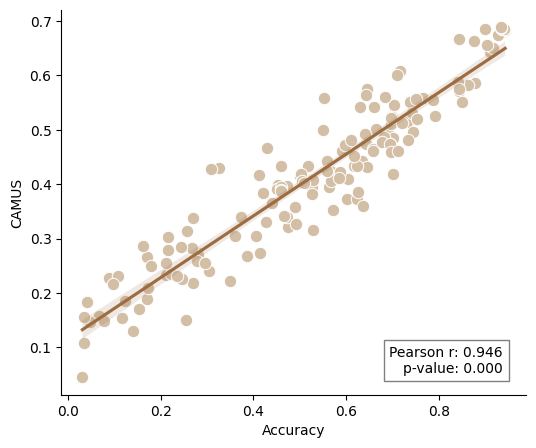

In [9]:
# Create a figure
plt.figure(figsize=(6, 5))

# Create a scatter plot
sns.scatterplot(df['Accuracy'], df['CAMUS'], s=80, color='#d3bfa6')

# Add a regression line
sns.regplot(x='Accuracy', y='CAMUS', data=df, scatter=False, line_kws={'color': '#9c6c43'})

# Add correlation coefficient text to the plot
plt.text(0.95, 0.05, f'Pearson r: {corr_coef:.3f}\np-value: {p_value:.3f}',
         ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Hide the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set labels and title
plt.xlabel('Accuracy')
plt.ylabel('CAMUS')
# Display the plot
plt.show()